### 統計學習與深度學習
### Homework 3


請將IPYNB檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。


### 第一題 [分類器、特徵建構、與Stacking]

(50%) 建構分類器時常會透過特徵選擇與Ensemble增強預測能力。本題的目的是讓大家練習這些技巧。本題使用一個中文姓名分類的資料集。這個資料集收集了10730個中文名(不含姓)，以及這些名子對應到的性別。本資料集的資料檔是**namesex_data_v2.csv**，共有三個欄位，gname, sex, fold:
* gname: 不含姓的中文名。
* sex: 1為男性，0為女性。
* fold: 為0 - 9的整數，做為後續切割資料集使用。

我們先將這個資料集讀入Numpy Array，並列印前十筆資料。

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('/Users/tingshow_liu/Downloads/機器學習與深度學習/作業/HW3/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

{'gname': '承憲', 'sex': '1', 'fold': '9'}
{'gname': '均平', 'sex': '1', 'fold': '7'}
{'gname': '思安', 'sex': '0', 'fold': '6'}
{'gname': '佑誠', 'sex': '1', 'fold': '3'}
{'gname': '乃馨', 'sex': '0', 'fold': '0'}
{'gname': '婕', 'sex': '0', 'fold': '0'}
{'gname': '冠瑜', 'sex': '0', 'fold': '1'}
{'gname': '冠學', 'sex': '1', 'fold': '0'}
{'gname': '立翰', 'sex': '1', 'fold': '2'}
{'gname': '以柔', 'sex': '0', 'fold': '6'}


In [70]:
import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

#### 實做限制
為了確保可以確實練習到重要技巧，禁用Pycaret (<https://pycaret.org/>) 這類可以自動化調教參數與Ensemble模型的工具。另外也禁止使用`sklearn.ensemble.Stacking.*`。你可以使用sklearn中Pre-processing工具函數與現成的分類器，但參數調教請自行處理。



#### 回答下面問題
#### Q1.1 (10%): 
使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。依照每筆資料其fold值切割為Training (fold <=6)、Validation (fold == 7)、Stacking (fold == 8)、Test (fold == 9)。每個資料集應有特徵Array(二維)以及Label Array(一維)。如前面提到的，每個名子應該要對應到全名以及單字的One-hot Encoding。比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。建構特徵表示時應依照個特徵出現的頻率篩選。特徵在訓練資料出現兩次或以上才納入。如果一個特徵被排除，這個特徵出現時應被歸為"\_Other_Feature_"。任何名子只要有出現未被納入的特徵，則其"\_Other_Feature_"的欄位值為1。

舉例而言，假設訓練資料集中有下面三個名子: 承恩、承德、恩賜。在經過特徵頻率篩選之後，只剩下以下特徵: 承、恩。其他特徵，如承恩、承德、恩賜、德、賜皆被排除。因此最後的特徵表示為:

Input | 承 | 恩 | \_Other_Feature_ |
------|----|----|-----------------|
承恩  | 1  | 1   |  1    |
承德  | 1  | 0   |  1  |
恩賜  | 0  | 1   |  1 |

最後應產生以下Numpy Array:
* x_train: Training Features
* y_train: Training Labels
* x_valid: Validation Features
* y_valid: Validation Labels
* x_stack: Stack Features
* y_stack: Stack Labels
* x_test: Test Features
* y_test: Test Labels

請列出每個Numpy Array的Shape以資查驗。

In [71]:
training = name_df.copy()
training = training[training.fold <= 6]
columnlist_train = list(training['name'])

In [72]:
for n in columnlist_train:
    if len(n) > 1:
        columnlist_train = np.append(columnlist_train, n[0])
        columnlist_train = np.append(columnlist_train, n[1])

In [73]:
columnlist_train = columnlist_train.tolist()
encodelist = []
for n in set(columnlist_train):
    if columnlist_train.count(n) > 1:
        encodelist.append(n)

In [74]:
len(encodelist)

1629

In [81]:
for n in encodelist:
    training[n] = 0
training['_Other_Feature_'] = 0

training

sex name  fold  宜瑄  雲  宜婕  淑  議  天  葶  ...  奕均  屏  欣蓉  月言  方  諼  樵  子嘉  \
2        0   思安     6   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
3        1   佑誠     3   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
4        0   乃馨     0   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
5        0    婕     0   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
6        0   冠瑜     1   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
...    ...  ...   ...  .. ..  .. .. .. .. ..  ...  .. ..  ..  .. .. .. ..  ..   
10724    1   捃偉     5   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
10725    1   嘉銘     3   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
10727    0   又華     3   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
10728    1   子晉     0   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   
10729    0   芸靜     2   0  0   0  0  0  0  0  ...   0  0   0   0  0  0  0   0   

       博謙  _Other_Feature_  
2       0                0  
3       0                0  
4       0                0  
5       0                0  
6       0                0  
...    ..              ...  
10724   0                0  
10725   0                0  
10727   0                0  
10728   0                0  
10729   0                0  

[7483 rows x 1633 columns]

In [76]:
for index, row in training.iterrows():
    name = row['name']
    cnt = 0
    if name in encodelist:
        training.at[index, name] = 1
        cnt += 1
    if len(name) > 1:
        word1 = name[0]
        word2 = name[1]
        if word1 in encodelist:
            training.at[index, word1] = 1
            cnt += 1
        if word2 in encodelist:
            training.at[index, word2] = 1
            cnt += 1
    if cnt != 3:
        training.at[index, '_Other_Feature_'] = 1

In [54]:
training = training.drop(['name'], axis=1)
training = training.drop(['fold'], axis=1)
y_train = training['sex'].copy()
x_train = training.copy()
x_train = x_train.drop(['sex'], axis=1)
x_train

宜瑄  雲  宜婕  淑  議  天  葶  智  瑞妤  忠  ...  奕均  屏  欣蓉  月言  方  諼  樵  子嘉  博謙  \
2       0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
3       0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
4       0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
5       0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
6       0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
...    .. ..  .. .. .. .. .. ..  .. ..  ...  .. ..  ..  .. .. .. ..  ..  ..   
10724   0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
10725   0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
10727   0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
10728   0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   
10729   0  0   0  0  0  0  0  0   0  0  ...   0  0   0   0  0  0  0   0   0   

       _Other_Feature_  
2                    1  
3                    1  
4                    1  
5                    1  
6                    1  
...                ...  
10724                1  
10725                1  
10727                1  
10728                1  
10729                1  

[7483 rows x 1630 columns]

In [10]:
validation = name_df.copy()
validation = validation[validation.fold == 7]
stacking = name_df.copy()
stacking = stacking[stacking.fold == 8]
test = name_df.copy()
test = test[test.fold == 9]

In [11]:
for n in encodelist:
    validation[n] = 0
    stacking[n] = 0
    test[n] = 0
validation['_Other_Feature_'] = 0
stacking['_Other_Feature_'] = 0
test['_Other_Feature_'] = 0

In [12]:
for index, row in validation.iterrows():
    name = row['name']
    cnt = 0
    if name in encodelist:
        validation.at[index, name] = 1
        cnt += 1
    if len(name) > 1:
        word1 = name[0]
        word2 = name[1]
        if word1 in encodelist:
            validation.at[index, word1] = 1
            cnt += 1
        if word2 in encodelist:
            validation.at[index, word2] = 1
            cnt += 1
    if cnt != 3:
        validation.at[index, '_Other_Feature_'] = 1

In [13]:
for index, row in stacking.iterrows():
    name = row['name']
    cnt = 0
    if name in encodelist:
        stacking.at[index, name] = 1
        cnt += 1
    if len(name) > 1:
        word1 = name[0]
        word2 = name[1]
        if word1 in encodelist:
            stacking.at[index, word1] = 1
            cnt += 1
        if word2 in encodelist:
            stacking.at[index, word2] = 1
            cnt += 1
    if cnt != 3:
        stacking.at[index, '_Other_Feature_'] = 1

In [14]:
for index, row in test.iterrows():
    name = row['name']
    cnt = 0
    if name in encodelist:
        test.at[index, name] = 1
        cnt += 1
    if len(name) > 1:
        word1 = name[0]
        word2 = name[1]
        if word1 in encodelist:
            test.at[index, word1] = 1
            cnt += 1
        if word2 in encodelist:
            test.at[index, word2] = 1
            cnt += 1
    if cnt != 3:
        test.at[index, '_Other_Feature_'] = 1

In [15]:
validation = validation.drop(['name'], axis=1)
stacking = stacking.drop(['name'], axis=1)
test = test.drop(['name'], axis=1)
validation = validation.drop(['fold'], axis=1)
stacking = stacking.drop(['fold'], axis=1)
test = test.drop(['fold'], axis=1)

In [16]:
y_valid = validation['sex'].copy()
x_valid = validation.copy()
x_valid = x_valid.drop(['sex'], axis=1)
y_stack = stacking['sex'].copy()
x_stack = stacking.copy()
x_stack = x_stack.drop(['sex'], axis=1)
y_test = test['sex'].copy()
x_test = test.copy()
x_test = x_test.drop(['sex'], axis=1)

In [17]:
print(x_train.shape)
print(x_valid.shape)
print(x_stack.shape)
print(x_test.shape)

(7483, 1630)
(1110, 1630)
(1073, 1630)
(1064, 1630)


#### Q1.2 (10%):
使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型。利用Training與Validation調教Regularization Coefficient $c$。Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。取F-1 Score最大之Regularization Coefficient，印出此數值(以下稱bestc)。將Training與Validation合併後，令Regularizaiton Coefficient為bestc，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出係數絕對值最大的20個特徵。注意應列出未取絕對值的係數數值，方知特徵的性別傾向。討論Prediction Performance與重要特徵的合理性。


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

c_list = np.geomspace(0.0001, 1000, num=20)

In [19]:
bestc = c_list[0]
bestf1 = 0
for c in c_list:
    lm = LogisticRegression(C=c, max_iter = 1000)
    lm.fit(x_train, y_train)
    y_result = lm.predict(x_valid)
    f1 = f1_score(y_valid, y_result)
    if c == c_list[0]:
        bestf1 = f1
    if f1 > bestf1:
        bestc = c
        bestf1 = f1
print('best c: ', bestc)
print('best f1: ', bestf1)

best c:  78.47599703514607
best f1:  0.8991517436380773


In [20]:
x_train2 = pd.concat([x_train, x_valid], ignore_index=True)
y_train2 = pd.concat([y_train, y_valid], ignore_index=True)
lm = LogisticRegression(C=100, max_iter = 1000)
lm.fit(x_train2, y_train2)
y_result = lm.predict(x_test)
lm_result = lm.predict_proba(x_test)
ncorrect = np.sum(y_test == y_result)
accuracy = ncorrect / len(y_test)
print("Accuracy = %f" % accuracy)
recall = recall_score(y_test, y_result)
print("Recall = %f" % recall)  
precision = precision_score(y_test, y_result)
print("Precision = %f" % precision)  
f1 = f1_score(y_test, y_result)
print("f1 = %f" % f1)
print('lm.coef_: ', lm.coef_[0])

Accuracy = 0.885338
Recall = 0.893224
Precision = 0.861386
f1 = 0.877016
lm.coef_:  [-0.07285688 -0.3177396  -0.00564134 ... -0.45529967 -0.17112085
 -0.07002819]


In [21]:
rank = pd.DataFrame(columns = ['index', 'coef', 'abs'])
rank['index'] = np.array([i for i in range(1630)])
rank['coef'] = lm.coef_[0]
rank['abs'] = abs(rank['coef'])

#### 列出係數絕對值最大的20個特徵

In [22]:
rank = rank.sort_values('abs', ascending=False)[0:20]
rank

index      coef       abs
687     687  9.799040  9.799040
1411   1411  9.249052  9.249052
1156   1156 -9.118468  9.118468
642     642 -8.882785  8.882785
300     300 -8.880862  8.880862
792     792 -8.839320  8.839320
1500   1500  8.769269  8.769269
786     786 -8.711779  8.711779
1185   1185 -8.685989  8.685989
821     821 -8.643345  8.643345
299     299 -8.599918  8.599918
975     975 -8.591484  8.591484
475     475 -8.475178  8.475178
1041   1041 -8.413621  8.413621
396     396 -8.347989  8.347989
1590   1590 -8.273080  8.273080
1339   1339 -8.268426  8.268426
635     635  8.018437  8.018437
446     446  7.971964  7.971964
1507   1507 -7.938394  7.938394

In [23]:
for i in range(20):
    print(x_train2.columns[rank.iloc[i,0]], rank.iloc[i,1])

傑 9.799039781111329
森 9.249051523264914
玲 -9.118467645887877
雯 -8.882784781488393
凌 -8.880862185666105
婷 -8.839320386420587
鋒 8.76926854582955
美 -8.71177897038819
萱 -8.685989103320962
薇 -8.643344730396446
綾 -8.59991782933252
婕 -8.591484344736106
嵐 -8.475178135891543
妤 -8.413621027763622
潔 -8.347988558401125
絃 -8.27308031912515
卉 -8.268426470492907
松 8.018437273208583
顥 7.971964210031722
靜 -7.938394376586197


#### 討論Prediction Performance與重要特徵的合理性。
係數絕對值很大的那些字或名字幾乎都是比較好判斷性別的（較常出現在男或女其中一個性別的名字中），因此若出現一個很大的值（絕對值很大且原始值為正），則有高機率是男生；反之則有高機率是女生。

#### Q1.3 (10%):
使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型。利用Training與Validation調教Number of Tress (i.e., n_estimators)。Grid Search的小值為$5$，最大值是$1,000$，總共取10個點，使用等比級數間隔。取F-1 Score最大之n_estimators，印出此數值(best_nest)。將Training與Validation合併後，令n_estimators為best_nest，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [24]:
from sklearn.ensemble import RandomForestClassifier
n_list = np.geomspace(5, 1000, num=10)
for i in range(len(n_list)):
    n_list[i] = round(n_list[i])
n_list

array([   5.,    9.,   16.,   29.,   53.,   95.,  171.,  308.,  555.,
       1000.])

In [25]:
n_list = [5, 9, 16, 29, 53, 95, 171, 308, 555, 1000]
bestn = n_list[0]
bestf1 = 0
for n in n_list:
    rm = RandomForestClassifier(n_estimators=n)
    rm.fit(x_train, y_train)
    y_result = lm.predict(x_valid)
    f1 = f1_score(y_valid, y_result)
    if n == n_list[0]:
        bestf1 = f1
    if f1 > bestf1:
        bestn = n
        bestf1 = f1
print('best n: ', bestn)
print('best f1: ', bestf1)

best n:  5
best f1:  0.9271523178807946


In [26]:
x_train2 = pd.concat([x_train, x_valid], ignore_index=True)
y_train2 = pd.concat([y_train, y_valid], ignore_index=True)
rm = RandomForestClassifier(n_estimators=bestn)
rm.fit(x_train2, y_train2)
y_result = rm.predict(x_test)
rm_result = rm.predict_proba(x_test)
ncorrect = np.sum(y_test == y_result)
accuracy = ncorrect / len(y_test)
print("Accuracy = %f" % accuracy)
recall = recall_score(y_test, y_result)
print("Recall = %f" % recall)  
precision = precision_score(y_test, y_result)
print("Precision = %f" % precision)  
f1 = f1_score(y_test, y_result)
print("f1 = %f" % f1)
print('lm.coef_: ', lm.coef_[0])

Accuracy = 0.839286
Recall = 0.819302
Precision = 0.827801
f1 = 0.823529
lm.coef_:  [-0.07285688 -0.3177396  -0.00564134 ... -0.45529967 -0.17112085
 -0.07002819]


In [27]:
important_features = rm.feature_importances_
index = (-important_features).argsort()[:20]
for i in index:
    print(x_train2.columns[i], important_features[i])

妤 0.022176680283023817
萱 0.014335753194714404
婷 0.01376875915804919
翔 0.012170316594398402
怡 0.010630910106324349
宜 0.009669191624218447
柏 0.009583962220279666
晴 0.009483765226728877
蓁 0.009332349974394059
雅 0.009115203403586014
芸 0.009050989118583201
柔 0.008880746125964607
涵 0.008855656698662983
瑄 0.008721507898537663
庭 0.008599346803583957
佳 0.008596611191265481
慈 0.008566827137830451
婕 0.00798026021882689
欣 0.007798948311558249
瑜 0.007554525131700632


#### 討論Prediction Performance與重要特徵的合理性。
被選為重要特徵的那些字或名字幾乎都是比較好判斷性別的（較常出現在男或女其中一個性別的名字中），因此會有利於預測。

#### Q1.4 (10%):
使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型。利用Training與Validation調教learning_rate與n_estimators。考慮以下Learning Rate: 0.1, 0.5, 1。每一個Learning Rate設n_estimator為1,500並估計一個GBDT分類器，計算1,500個Stages下Validation F-1 Score值，繪圖，並找出讓F-1 Score最大的Stage與F-1 Score最大值。對所有Learning Rate重複同樣程序，找出最佳的Learning Rate (稱best_lr) 與其對應的Number of Stages(best_nstg)。將Training與Validation合併後，令learning_rate為best_lr, n_estimators為best_nstg，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
l_list = [0.1, 0.5, 1]

----- learning rate =  0.1  ----------
best stage:  1134
best f1:  0.9060465116279071


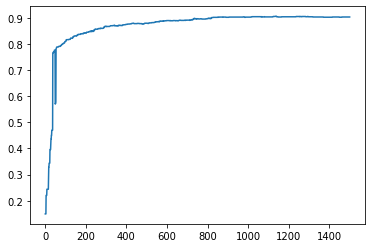

----- learning rate =  0.5  ----------
best stage:  229
best f1:  0.902143522833178


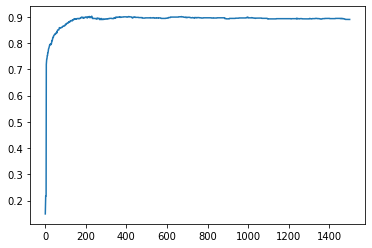

----- learning rate =  1  ----------
best stage:  228
best f1:  0.901222953904045


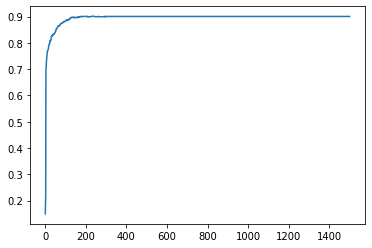

In [29]:
for l in l_list:
    bestf1 = 0
    beststage = 0
    f1_list = []
    gm = GradientBoostingClassifier(learning_rate = l, n_estimators = 1500)
    gm.fit(x_train, y_train)
    for i, y_result in enumerate(gm.staged_predict(x_valid)):
        f1 = f1_score(y_valid, y_result)
        f1_list.append(f1)
        if f1 > bestf1:
            beststage = i
            bestf1 = f1
    print('----- learning rate = ', l, ' ----------')
    print('best stage: ', beststage)
    print('best f1: ', bestf1)
    stage = np.linspace(1,1500,1500)
    plt.plot(stage,f1_list)
    plt.show()

In [30]:
x_train2 = pd.concat([x_train, x_valid], ignore_index=True)
y_train2 = pd.concat([y_train, y_valid], ignore_index=True)
gm = GradientBoostingClassifier(learning_rate = 0.5, n_estimators = 222)
gm.fit(x_train2, y_train2)
y_result = gm.predict(x_test)
gm_result = gm.predict_proba(x_test)
ncorrect = np.sum(y_test == y_result)
accuracy = ncorrect / len(y_test)
print("Accuracy = %f" % accuracy)
recall = recall_score(y_test, y_result)
print("Recall = %f" % recall)  
precision = precision_score(y_test, y_result)
print("Precision = %f" % precision)  
f1 = f1_score(y_test, y_result)
print("f1 = %f" % f1)

Accuracy = 0.874060
Recall = 0.897331
Precision = 0.838772
f1 = 0.867063


In [31]:
important_features = gm.feature_importances_
index = (-important_features).argsort()[:20]
for i in index:
    print(x_train2.columns[i], important_features[i])

妤 0.02999577520884969
翔 0.021973977299799847
柏 0.02060762652830009
萱 0.020068587723207954
婷 0.018997740768845375
哲 0.012943587939991808
承 0.012699263286670471
蓁 0.012647733289339717
怡 0.012107957834888309
宜 0.011561218848450638
晴 0.011493546527998371
雅 0.01128297293807638
柔 0.011175829635484032
佳 0.01091555071653724
涵 0.010865996827544603
芸 0.010752122801532439
芷 0.010559662413552407
慈 0.010147610931425962
瑜 0.01006862444356967
庭 0.009827363763720115


#### 討論Prediction Performance與重要特徵的合理性。
被選為重要特徵的那些字或名字幾乎都是比較好判斷性別的（較常出現在男或女其中一個性別的名字中），因此會有利於預測。

#### Q1.5 (10%):
取用前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree, 組合(Stacking)成一個新的分類器。我們使用Logistic Regression without Penalty建構這個Stacking分類器。訓練資料為Stacking資料集。各分類器輸入的特徵為男生預測機率(注意: 不是分類結果)。列出Stacking分類器的係數，討論係數的意義，並計算這個Stacking分類器在Test資料集的預測能力。

In [32]:
lm.fit(x_train2, y_train2)
lm_result = lm.predict_proba(x_stack)
rm.fit(x_train2, y_train2)
rm_result = rm.predict_proba(x_stack)
gm.fit(x_train2, y_train2)
gm_result = gm.predict_proba(x_stack)

In [33]:
from sklearn.ensemble import StackingClassifier
df = pd.DataFrame(columns = ['lm', 'rm', 'gm'])
lm_model = lm_result[:,1]
rm_model = rm_result[:,1]
gm_model = gm_result[:,1]
df['lm'] = lm_model
df['rm'] = rm_model
df['gm'] = gm_model
lm2 = LogisticRegression(penalty='none',)
lm2.fit(df, y_stack)
lm2.coef_

array([[ 2.88625579, -0.25537322,  5.18049256]])

分類器的係數表示他對 meta learner 的貢獻程度

In [34]:
lm_result = lm.predict_proba(x_test)
rm_result = rm.predict_proba(x_test)
gm_result = gm.predict_proba(x_test)
lm_result = lm_result[:,1]
rm_result = rm_result[:,1]
gm_result = gm_result[:,1]
df_result = pd.DataFrame(columns = ['lm', 'rm', 'gm'])
df_result['lm'] = lm_result
df_result['rm'] = rm_result
df_result['gm'] = gm_result

In [35]:
y_pred = lm2.predict(df_result)

在測試集的預測能力

In [36]:
ncorrect = np.sum(y_test == y_pred)
accuracy = ncorrect / len(y_test)
print("Accuracy = %f" % accuracy)
recall = recall_score(y_test, y_pred)
print("Recall = %f" % recall)  
precision = precision_score(y_test, y_pred)
print("Precision = %f" % precision)  
f1 = f1_score(y_test, y_pred)
print("f1 = %f" % f1)

Accuracy = 0.885338
Recall = 0.897331
Precision = 0.858546
f1 = 0.877510


## 第二題 [Data Visualization via Dimensionality Reduction]

Data visualization is a useful technique that can help us understand the characteristics of a dataset. We are going to practice this skill using the  University Offer of Admission Dataset (UDOAD).  

#### Dataset: University Department Offer of Admission Dataset (UDOAD; 大學推薦甄選資料集)

In [62]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()
colname = all_stuid.copy()


depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    dep_stu[dep_seq, stu_seq] = 1
    
#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))
print('rowname: ', rowname, len(rowname))

# Now both conditions are satisfied.
# Report the number of academic departments and student applicants in the processed dataset:
num_dep, num_stu = dep_stu2.shape
print("In final dataset, there are", num_dep, "academic departments and", num_stu, "student applicants.")

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0
rowname:  ['001012' '001022' '001032' ... '150142' '151012' '151022'] 1917
In final dataset, there are 1917 academic departments and 47386 student applicants.


In [63]:
for index, row in uname.iterrows():
    if row['category_name'] == '其他':
        uname.loc[index, 'category_name'] = 'Other'
    elif row['category_name'] == '商業、管理及法律':
        uname.loc[index, 'category_name'] = 'Business, Management and Law'
    elif row['category_name'] == '工程、製造及營建':
        uname.loc[index, 'category_name'] = 'Engineering, Manafacturing and Construction'
    elif row['category_name'] == '教育':
        uname.loc[index, 'category_name'] = 'Education'
    elif row['category_name'] == '服務':
        uname.loc[index, 'category_name'] = 'Service'
    elif row['category_name'] == '社會科學、新聞學及圖書資訊':
        uname.loc[index, 'category_name'] = 'Social Science, Journalism and Library Information'
    elif row['category_name'] == '自然科學、數學及統計':
        uname.loc[index, 'category_name'] = 'Natural Science, Math and Statostics'
    elif row['category_name'] == '藝術及人文':
        uname.loc[index, 'category_name'] = 'Art and Humanities'
    elif row['category_name'] == '資訊通訊科技':
        uname.loc[index, 'category_name'] = 'Computer and Communication Technology'
    elif row['category_name'] == '農業、林業、漁業及獸醫':
        uname.loc[index, 'category_name'] = 'Agriculture, Forestery, Fishery and Vetenary'
    elif row['category_name'] == '醫藥衛生及社會福利':
        uname.loc[index, 'category_name'] = 'Medicine and Social Welfare'

Report the top ten departments that received the most applications and the number of applications they received:

In [64]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

topdepid = np.argsort(dep_apply_sum)[::-1]
topn = 10
topdep = pd.DataFrame({'department_id': rowname[topdepid[0:topn]], 
                       'department_name': colname_df.depname.values[topdepid[0:topn]],
                       'num_applicant': dep_apply_sum[topdepid[0:topn]]
                       }) 
print(topdep)

  department_id department_name  num_applicant
0        008122         中原機械工程學          386.0
1        012052            中醫藥學          376.0
2        046032        銘傳會計（臺北）          367.0
3        004382            成大電機          357.0
4        005192          東吳企業管理          353.0
5        008112            中原土木          353.0
6        005182            東吳會計          351.0
7        015342            逢甲財金          340.0
8        045012            義守電機          339.0
9        046162      銘傳應用英語（桃園）          329.0


### Answer the following questions
Visualize academic departments in the following questions. In all plots, you should color data points according to the academic department's category. Moreover, you should provide a legend or a picture that illustrates the mapping between colors and category names. Visualize the data using two-dimensional plots. Note that it is your responsibility to study the documentation of your choice libraries and make sure that the results are reasonable. 
* Q2.1 (10%): Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories. 
* Q2.2 (10%): Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 
* Q2.3 (10%): Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result. 
* Q2.4 (10%): Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result. 
* Q2.5 (10%): Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result. 
* Q2.6 (10%) Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results. 

# Q 2.1

In [65]:
colname_df = colname_df.drop(columns=['depname', 'category_id'])

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(dep_stu2)
dep_stu2_pca = pca.transform(dep_stu2)
dep_stu2_pca = pd.concat([pd.DataFrame(dep_stu2_pca), colname_df.iloc[:,1]], axis=1)

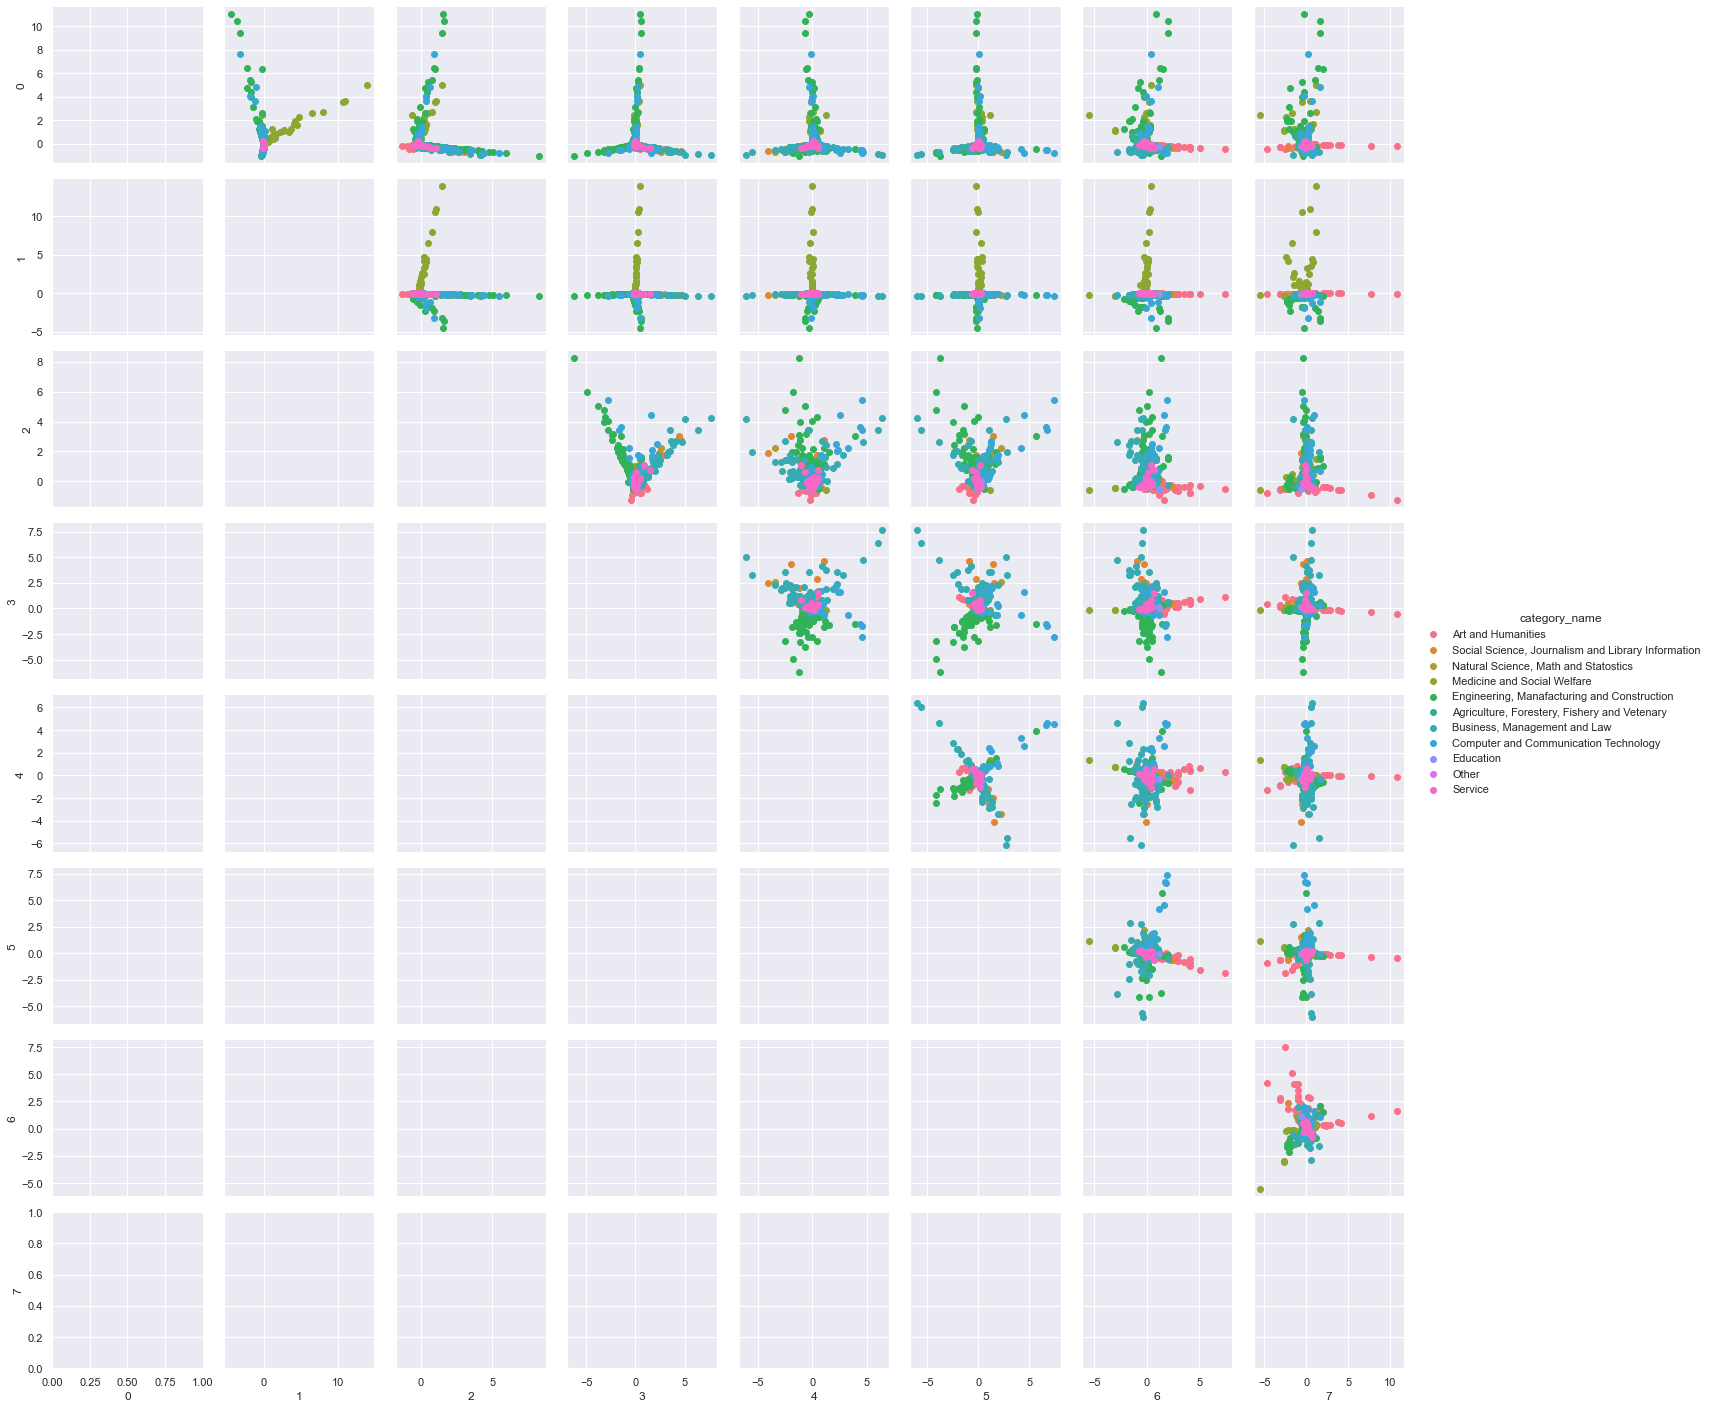

In [73]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})

g = sns.PairGrid(dep_stu2_pca, hue='category_name')
g.map_upper(plt.scatter)
g.add_legend()

#### Discuss the visual patterns concerning department categories.

幾乎所有都可以分出工程（綠色）、電腦通訊（藍色），第二個主成分可以分出較多醫藥公衛（黃綠色），第七、八個主成分可以分出較多藝術人文（粉紅色）

# Q 2.2

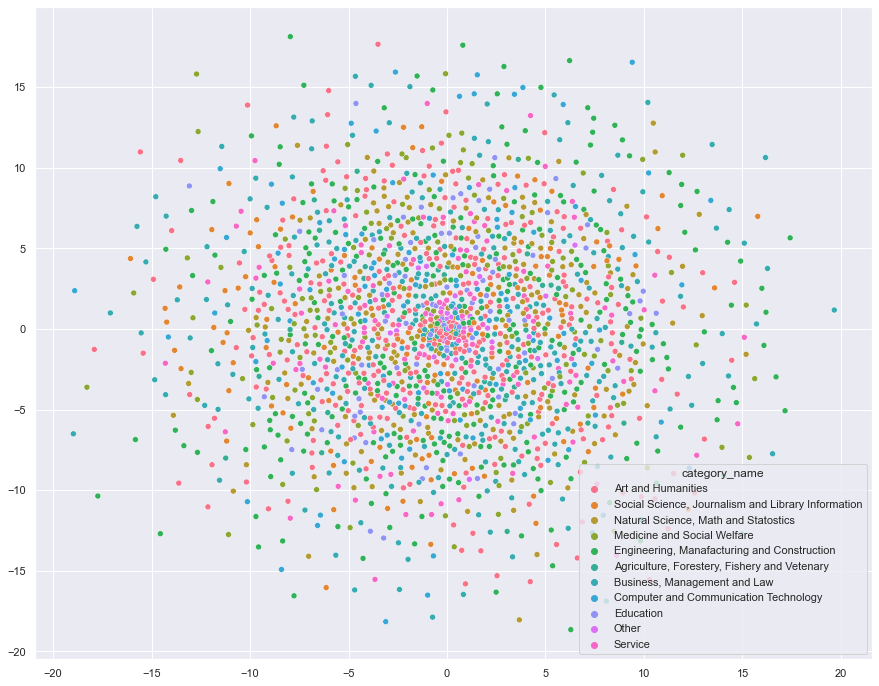

In [ ]:
from sklearn.manifold import MDS
MMDS = MDS()
dep_stu2_MMDS = MMDS.fit_transform(dep_stu2)
g = sns.scatterplot(x=dep_stu2_MMDS[:,0], y=dep_stu2_MMDS[:,1], hue=colname_df.iloc[:,1])

<AxesSubplot:>

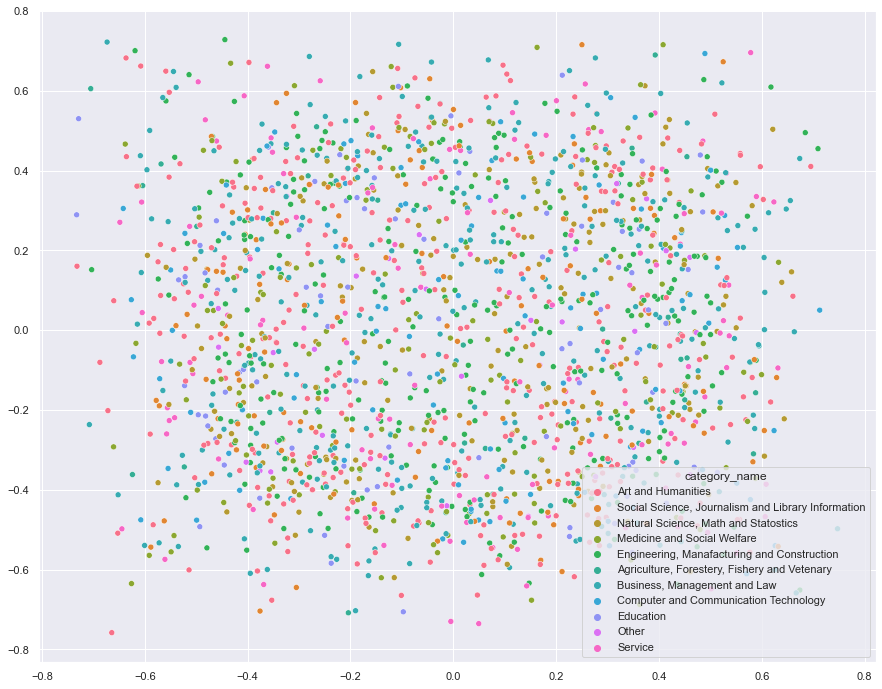

In [ ]:
NMDS = MDS(metric=False)
dep_stu2_NMDS = NMDS.fit_transform(dep_stu2)
sns.scatterplot(x=dep_stu2_NMDS[:,0], y=dep_stu2_NMDS[:,1], hue=colname_df.iloc[:,1])

#### Discuss the result.
使用 multiple dimensional scaling 時，不論是 metric 或 non-metric，都沒辦法分出類別，而 metric 的散佈呈現橢圓形， non-metric 的較為平均。

# Q2.3

n_neighbors改為10和15

<AxesSubplot:>

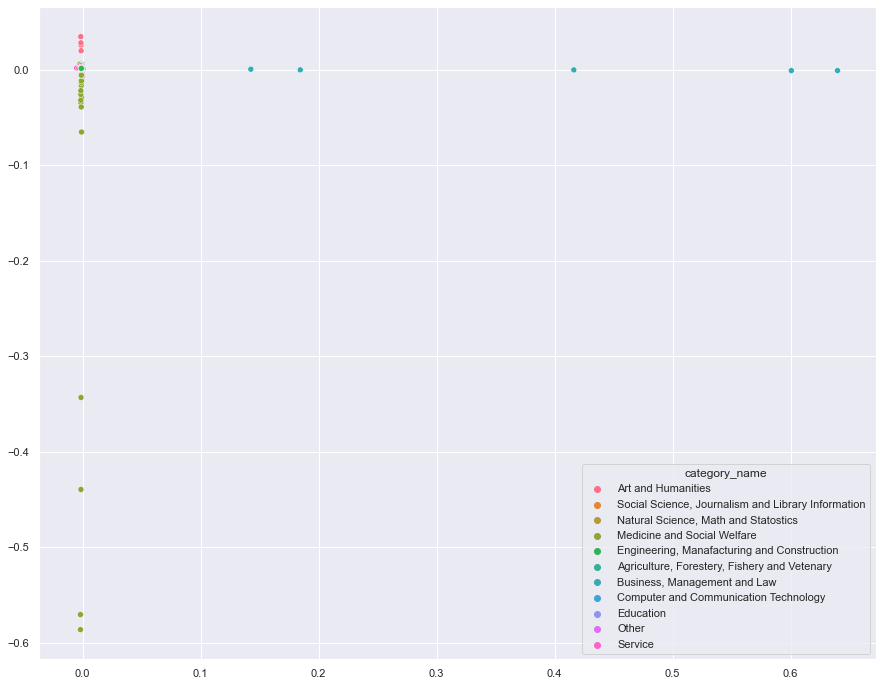

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
LLE20 = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
dep_stu2_LLE20 = LLE20.fit_transform(dep_stu2)
sns.scatterplot(x=dep_stu2_LLE20[:,0], y=dep_stu2_LLE20[:,1], hue=colname_df.iloc[:,1])

<AxesSubplot:>

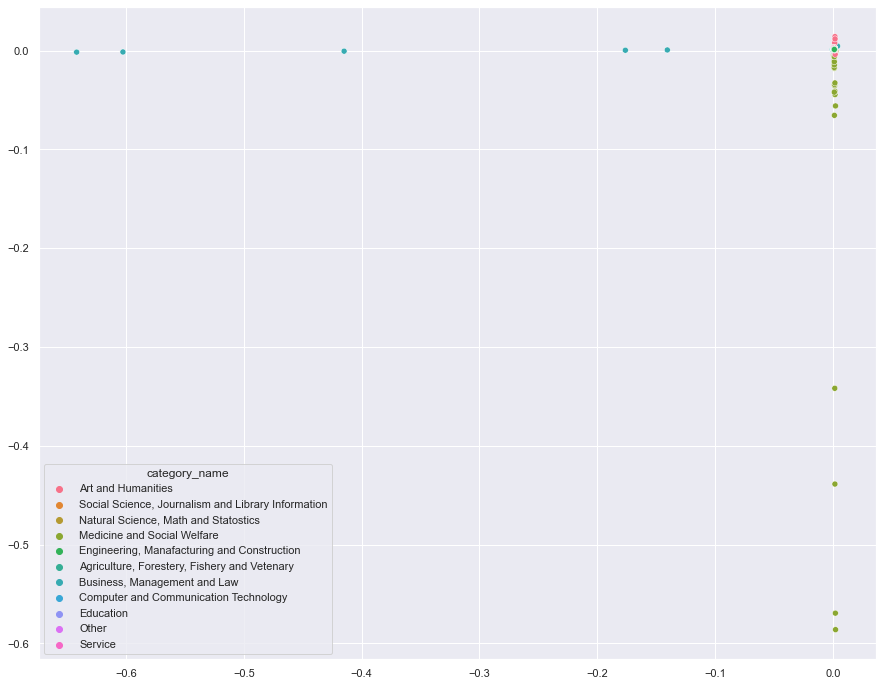

In [ ]:
LLE40 = LocallyLinearEmbedding(n_components=2,n_neighbors=15)
dep_stu2_LLE40 = LLE40.fit_transform(dep_stu2)
sns.scatterplot(x=dep_stu2_LLE40[:,0], y=dep_stu2_LLE40[:,1], hue=colname_df.iloc[:,1])

<AxesSubplot:>

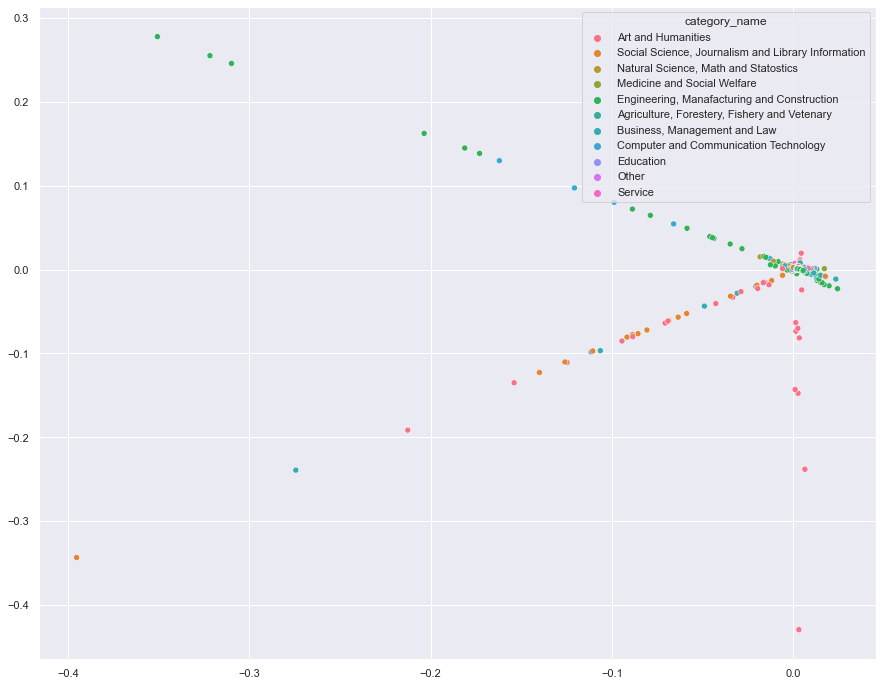

In [ ]:
pca = PCA(n_components=100)
pca.fit(dep_stu2)
dep_stu2_pca = pca.transform(dep_stu2)
LLE_pca = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
dep_stu2_LLE_pca = LLE_pca.fit_transform(dep_stu2_pca)
sns.scatterplot(x=dep_stu2_LLE_pca[:,0], y=dep_stu2_LLE_pca[:,1], hue=colname_df.iloc[:,1])

#### Discuss the result.

LLE 10 和 LLE 15 的時候，主要是被分為三類

PCA 加 LLE 後，可以分出更多的領域

# Q 2.4

In [11]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

param_grid = [{
        "gamma":[0.001,0.01,0.1,1,10,100,1000],
        "kernel": ["rbf", "cosine"]
    }]

kpca = KernelPCA(fit_inverse_transform=True, n_components=2)
grid_search = GridSearchCV(kpca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(dep_stu2)

GridSearchCV(cv=3, error_score=nan,
             estimator=KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3,
                                 eigen_solver='auto',
                                 fit_inverse_transform=True, gamma=None,
                                 kernel='linear', kernel_params=None,
                                 max_iter=None, n_components=2, n_jobs=None,
                                 random_state=None, remove_zero_eig=False,
                                 tol=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf', 'cosine']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function my_scorer at 0x7faac478c8c8>, verbose=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


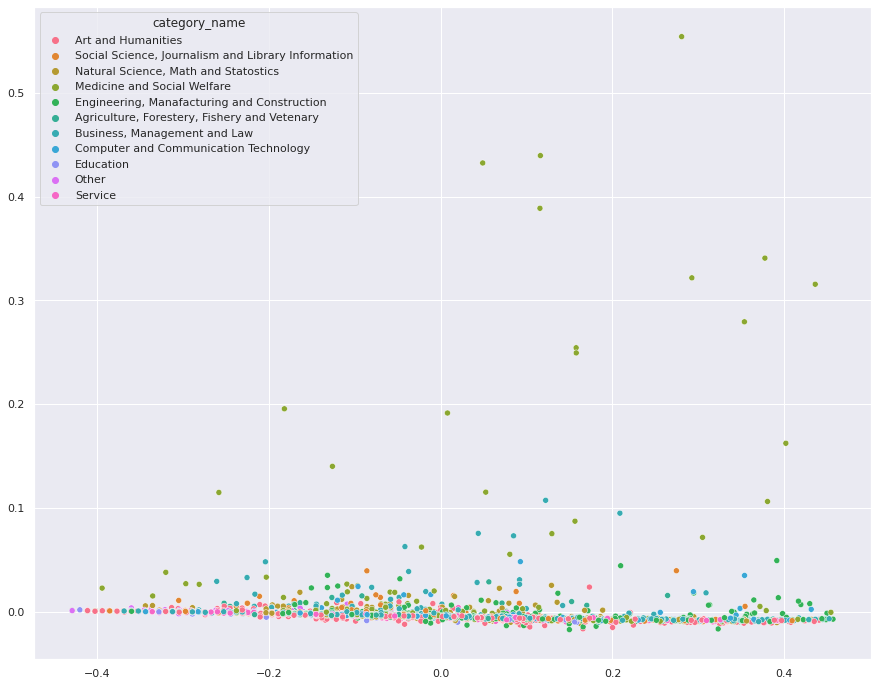

In [12]:
kpca = KernelPCA(kernel='linear', n_components=2, alpha=1.0, coef0=1, gamma=0.001)
dep_stu2_kpca = kpca.fit_transform(dep_stu2)

sns.scatterplot(x=dep_stu2_kpca[:,0], y=dep_stu2_kpca[:,1], hue=colname_df.iloc[:,1])

#### Discuss the result.
可以分出醫藥類，但其他混在一起

## Q 2.5

<AxesSubplot:>

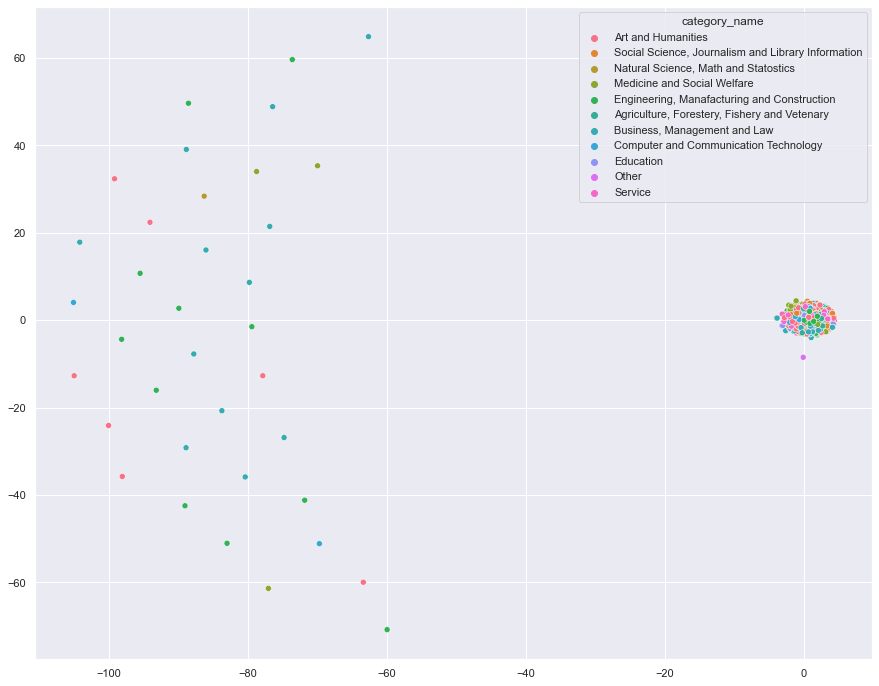

In [60]:
from sklearn.manifold import TSNE

tsne_euclidian = TSNE(n_components=2, random_state=1, metric='euclidean')
dep_stu2_tsne_euclidian = tsne_euclidian.fit_transform(dep_stu2)
sns.scatterplot(x=dep_stu2_tsne_euclidian[:,0], y=dep_stu2_tsne_euclidian[:,1], hue=colname_df.iloc[:,1])

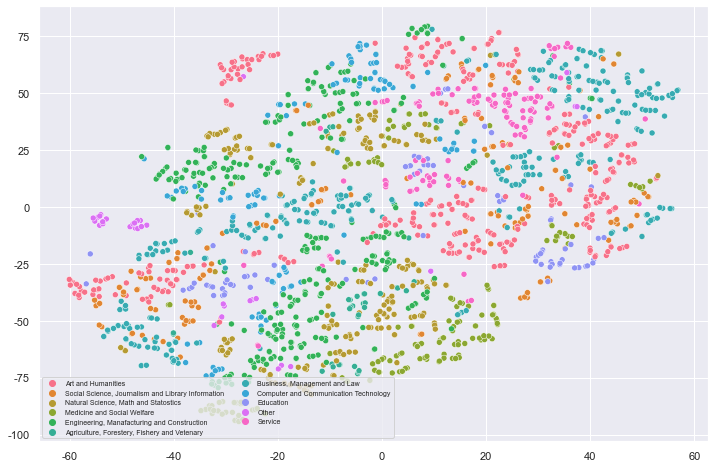

In [ ]:
tsne_cosine = TSNE(n_components=2, random_state=1, metric='cosine')
dep_stu2_tsne_cosine = tsne_Cosine.fit_transform(dep_stu2)
sns.scatterplot(x=dep_stu2_tsne_cosine[:,0], y=dep_stu2_tsne_cosine[:,1], hue=colname_df.iloc[:,1])

<AxesSubplot:>

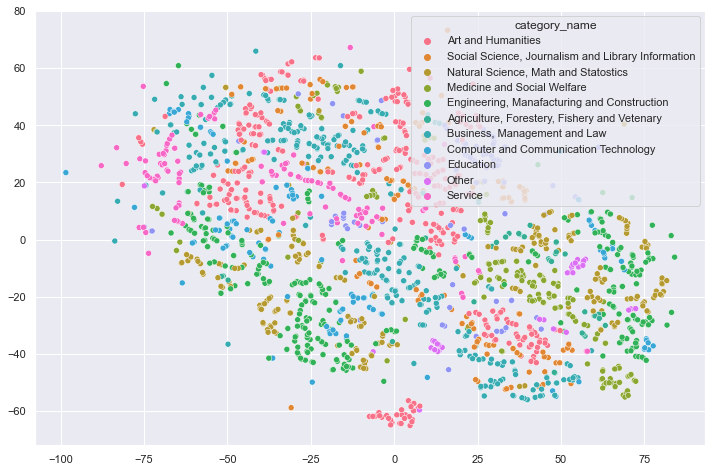

In [ ]:
tsne_jaccard = TSNE(n_components=2, random_state=1, metric='jaccard')
dep_stu2_tsne_jaccard = tsne_jaccard.fit_transform(dep_stu2)
sns.scatterplot(x=dep_stu2_tsne_jaccard[:,0], y=dep_stu2_tsne_jaccard[:,1], hue=colname_df.iloc[:,1])

#### Discuss the result.
Euclidian 的形狀最為特殊，無法區分。其餘兩種皆可見部分聚集的情況。

## Q 2.6

In [ ]:
sns.set(rc={'figure.figsize':(150,120)})
sns.set(font=['sans-serif'])
sns.set_style("darkgrid",{"font.sans-serif":['SimHei']})

school_department = colname_df.merge(uname,[['department_id','depname']], on='department_id', how='inner')
output = sns.scatterplot(x=dep_stu2_tsne_jaccard[:,0], y=dep_stu2_tsne_jaccard[:,1], hue=school_department.iloc[:,1])

for line in range(0,dep_stu2_tsne_jaccard.shape[0]):
     output.text(dep_stu2_tsne_jaccard[line,0], dep_stu2_tsne_jaccard[line,1], school_department.iloc[line,-1], horizontalalignment='left', color='black', weight='semibold')

plt.savefig('output.png')
plt.show()
plt.close()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 63972 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 63972 missing from current font.
  font.set_text(s, 0, flags=flags)
